In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

In [2]:
prefix = "MAT_small_ATTP_"
filename = "ms_small_attp_filtered_combined.txt"
s = open(filename, "r").readlines()    

In [3]:
raw_pr = []
raw_mem = []
raw_time = []
raw_final_mem = []
ln = 0
query_type = ""
flagFinal = False
for line in s:
    if line.startswith("START_OF_FINAL_STATS_REPORT"):
        flagFinal = True
    if line.startswith("Stats request at line"):
        ln = int(re.findall("\d+", line)[1])
        flagFinal = False
    if line.find(" timers") != -1:
        query_type = line.strip().split(" ")[0]
    if line.find(" ms = ") != -1:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        sketch = [sketch[0], ''.join(sketch[1:])]
        raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
    if line.find("||ATA-BTB||_2 / ||A||_F^2") != -1:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        sketch = [sketch[0], ''.join(sketch[1:])]
        pr_info = float(t[1].split('=')[-1])
        raw_pr.append(sketch + [pr_info])
    if line.find("MB") != -1:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
        if flagFinal:
            raw_final_mem.append(t)
        else:
            raw_mem.append(t)

In [4]:
mem = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,NORM_SAMPLING,ss10,500,46816
1,NORM_SAMPLING,ss25,500,93056
2,NORM_SAMPLING,ss50,500,154656
3,NORM_SAMPLING,ss100,500,253056
4,NORM_SAMPLING,ss150,500,319456
...,...,...,...,...
2295,NORM_SAMPLING_WR,ss700,48000,2929792
2296,NORM_SAMPLING_WR,ss700,48500,2933296
2297,NORM_SAMPLING_WR,ss700,49000,2937872
2298,NORM_SAMPLING_WR,ss700,49500,2943808


In [5]:
time = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Time (ms)"])
time_processed = pd.merge(time, mem, on = ["Sketch", "Param", "Stream Size"]).drop_duplicates()
utime = time_processed[time_processed["Type"] == "Update"]
utime

,Sketch,Param,Stream Size,Type,Time (ms),Memory Usage (B)
0,NORM_SAMPLING,ss10,500,Update,0,46816
2,NORM_SAMPLING,ss25,500,Update,0,93056
4,NORM_SAMPLING,ss50,500,Update,0,154656
6,NORM_SAMPLING,ss100,500,Update,0,253056
8,NORM_SAMPLING,ss150,500,Update,0,319456
...,...,...,...,...,...,...
4634,NORM_SAMPLING_WR,ss700,48000,Update,597,2929792
4636,NORM_SAMPLING_WR,ss700,48500,Update,603,2933296
4638,NORM_SAMPLING_WR,ss700,49000,Update,610,2937872
4640,NORM_SAMPLING_WR,ss700,49500,Update,616,2943808


In [6]:
pr = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Error"])
final_mem = pd.DataFrame(raw_final_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
pr = pd.merge(pr, final_mem, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage (B)"]).mean().drop("Stream Size", 1)
pr = pd.DataFrame(pr.to_records())
pr

,Sketch,Param,Memory Usage (B),Error
0,NORM_SAMPLING,ss10,84416,0.173574
1,NORM_SAMPLING,ss100,641056,0.040246
2,NORM_SAMPLING,ss150,897056,0.035551
3,NORM_SAMPLING,ss200,1173856,0.036193
4,NORM_SAMPLING,ss25,193856,0.092539
5,NORM_SAMPLING,ss400,2128256,0.032342
6,NORM_SAMPLING,ss50,348256,0.063810
7,NORM_SAMPLING,ss600,2939456,0.024753
8,NORM_SAMPLING_WR,ss10,89504,0.186801
9,NORM_SAMPLING_WR,ss100,581264,0.082256


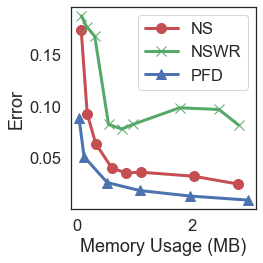

In [7]:
fig, ax = plt.subplots(figsize = (4, 4))
sketch_type = ["NORM_SAMPLING", "NORM_SAMPLING_WR", "PFD"]
sketch_param = {
    "NORM_SAMPLING" : ["ss10", "ss200"],
    "NORM_SAMPLING_WR" : ["ss10", "ss200"],
    "PFD" : ["l10", "l100"],
}
abbrv = {
    "NORM_SAMPLING" : "NS",
    "NORM_SAMPLING_WR" : "NSWR",
    "PFD" : "PFD",    
}
        
linestyles = ["-", "--", "."]
colors = ["r", "g", "b"]
markers = ["o", "x", "^"]
ms = 10
lw = 3

cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[2] / 1048576.0, dat[3], color = colors[cnt], marker = markers[cnt], label = abbrv[sk], markersize = ms, linewidth = lw)
    cnt += 1
ax.legend()
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Error")
plt.tight_layout()
plt.savefig(prefix + 'err.pdf')

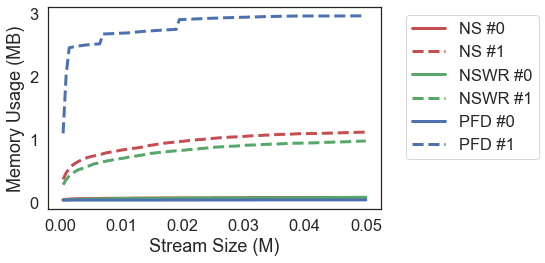

In [8]:
fig, ax = plt.subplots(figsize = (8, 4))
cnt = 0

for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = mem[(mem["Sketch"] == sk) & (mem["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[2] / 1000000.0, dat[3] / 1048576.0, label = "%s #%d" % (abbrv[sk], cnt0), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel("Stream Size (M)")
ax.set_ylabel("Memory Usage (MB)")
plt.tight_layout()
plt.savefig(prefix + 'mem.pdf')

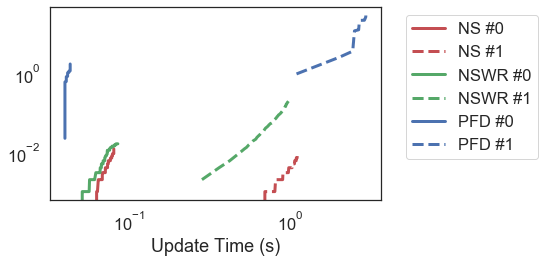

In [9]:
fig, ax = plt.subplots(figsize = (8, 4))
cnt = 0
for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = utime[(utime["Sketch"] == sk) & (utime["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[-1] / 1048576.0, dat[-2] / 1000.0, label = "%s #%d" % (abbrv[sk], cnt0), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_xlabel("Update Time (s)")
plt.tight_layout()
plt.savefig(prefix + 'time.pdf')